# Imports

In [54]:
import tensorflow as tf
from keras import Model
import matplotlib.pyplot as plt
import cv2
from keras.applications import DenseNet121
from keras.layers import *
from keras.callbacks import *

# GPU

In [55]:
!nvidia-smi

Sun May 28 22:12:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.41       Driver Version: 527.41       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:2B:00.0  On |                  N/A |
| 47%   51C    P2    42W / 175W |   7787MiB /  8192MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Creating variables containing frequently used directories, and printing out number of images in data set

215 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_classes\test\Glioma'.
107 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_classes\test\Meningioma'.
140 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_classes\test\Pituitary'.
998 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_classes\train\Glioma'.
495 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_classes\train\Meningioma'.
651 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_classes\train\Pituitary'.
213 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_classes\val\Glioma'.
106 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_classes\val\Meningioma'.
139 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_classes\val\Pituitary'.
['Glioma', 'Meningioma', 'Pituitary']


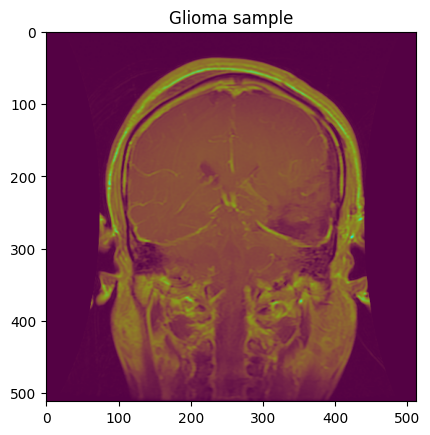

In [56]:
for dirpath, dirnames, filenames in os.walk("C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_classes"):
    if len(filenames) != 0:
        print(f"{len(filenames)} images in '{dirpath}'.")

train_dir = "C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_classes/train/"
test_dir = "C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_classes/test/"
val_dir = "C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_classes/val/"

classes = []
for name in os.listdir(train_dir):
    classes.append(name)

print(classes)

img_array = cv2.imread("C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_classes/train/Glioma/0.png", 1)
plt.imshow(np.real(img_array))
plt.title("Glioma sample")
plt.show()

In [57]:
# Declaring ImageDataGenerator

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=5)
test_datagen = ImageDataGenerator(rescale = 1/255)

In [58]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

val_data = train_datagen.flow_from_directory(val_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Found 2144 images belonging to 3 classes.
Found 462 images belonging to 3 classes.
Found 458 images belonging to 3 classes.


In [59]:
# Initializing model

base_model = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(IMAGE_SHAPE+(3,)))
)

In [60]:
# Adding weight classes, because our data set is unbalanced

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_data.classes),
                                                  y=train_data.classes)
class_weights = dict(enumerate(class_weights))

In [61]:
# Addding head of the model

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(256, activation='relu')(x)
x=Dropout(0.25)(x)
prediction=Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs = prediction)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_8[0][0]']       
                                )                                                           

In [62]:
# Compiling model

model.compile(optimizer=tf.keras.optimizers.SGD(),
    loss="BinaryCrossentropy",
    metrics=["accuracy"],
    )

In [63]:
# Initializing checkpoint class

from keras.callbacks import ModelCheckpoint

train_steps = train_data.samples // BATCH_SIZE
test_steps= test_data.samples // BATCH_SIZE
val_steps = val_data.samples // BATCH_SIZE

callback = ModelCheckpoint("best_model.hdf5",
                           monitor='val_loss',
                           verbose=1,
                           save_best_only=True,
                           mode='auto',
                           save_freq="epoch")

print(train_steps,  test_steps, val_steps)

67 14 14


In [64]:
# Fitting existing model with freezed trainable layers to our data

history = model.fit(
    train_data,
    steps_per_epoch=train_steps,
    epochs = 5,
    validation_data=val_data,
    validation_steps=val_steps,
    callbacks=[callback],
    class_weight=class_weights
)

Epoch 1/5
67/67 [==============================] - ETA: 0s - loss: 0.4433 - accuracy: 0.7225
Epoch 1: val_loss improved from inf to 0.68952, saving model to best_model.hdf5
67/67 [==============================] - 50s 633ms/step - loss: 0.4433 - accuracy: 0.7225 - val_loss: 0.6895 - val_accuracy: 0.4643
Epoch 2/5
67/67 [==============================] - ETA: 0s - loss: 0.2275 - accuracy: 0.8773
Epoch 2: val_loss improved from 0.68952 to 0.34989, saving model to best_model.hdf5
67/67 [==============================] - 39s 577ms/step - loss: 0.2275 - accuracy: 0.8773 - val_loss: 0.3499 - val_accuracy: 0.7567
Epoch 3/5
67/67 [==============================] - ETA: 0s - loss: 0.1664 - accuracy: 0.9118
Epoch 3: val_loss improved from 0.34989 to 0.21058, saving model to best_model.hdf5
67/67 [==============================] - 38s 569ms/step - loss: 0.1664 - accuracy: 0.9118 - val_loss: 0.2106 - val_accuracy: 0.8683
Epoch 4/5
67/67 [==============================] - ETA: 0s - loss: 0.1312 - a

In [65]:
model.load_weights("best_model.hdf5") # Loading best weights that occured during all epochs

print(model.evaluate(test_data, steps=test_steps, return_dict=True)["accuracy"])

14/14 [==============================] - 6s 452ms/step - loss: 0.1567 - accuracy: 0.9174
0.9174107313156128


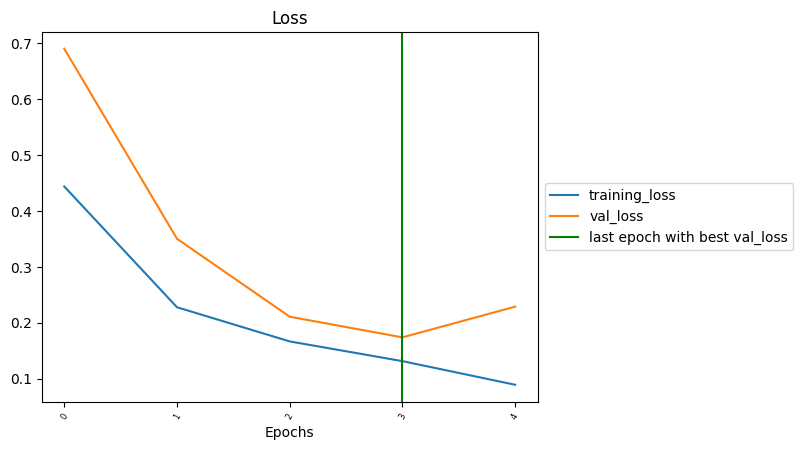

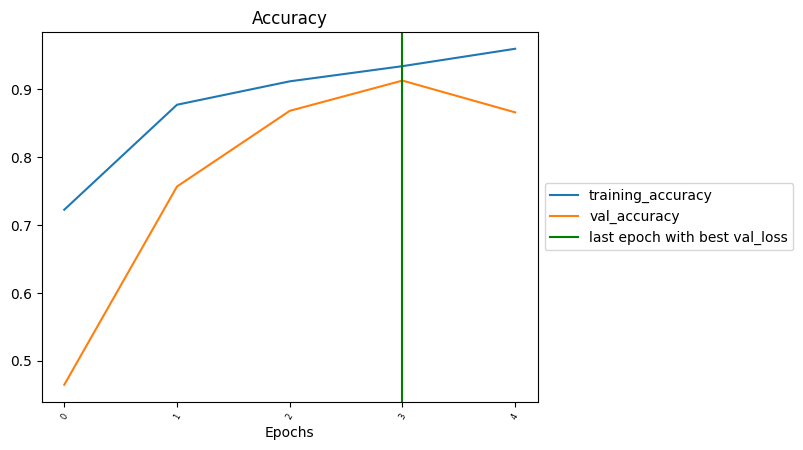

In [66]:
# Plotting model's preformance

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.axvline(x=np.argmin(history.history["val_loss"]), color="green", label='last epoch with best val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.xticks(ticks=np.arange(0, len(history.history['loss'])), rotation = 60, fontsize=6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.axvline(x=np.argmin(history.history["val_loss"]), color="green", label='last epoch with best val_loss')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.xticks(ticks=np.arange(0, len(history.history['loss'])), rotation = 60, fontsize=6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))